<a href="https://colab.research.google.com/github/HarjitG/Brain-Tumour-Classification/blob/Harjit-Dev/Colab_Notebook_Binaryipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
#import optuna
#import keras_tuner as kt
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [341]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [342]:
training_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Training'
testing_path = '/content/drive/MyDrive/projects/Brain_Tumor_Classification/Images_Brain/Testing'

In [343]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [344]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [345]:
# Load the training dataset
Training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',  # Automatically infer labels from the directory structure
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

# Load the validation dataset
Validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

# Load the testing dataset
Testing_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    labels='inferred',
    image_size=(256, 256),
    batch_size=32,
)

Found 2910 files belonging to 4 classes.
Using 2328 files for training.


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 2910 files belonging to 4 classes.
Using 582 files for validation.
Found 394 files belonging to 4 classes.


In [346]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()


In [347]:
batch_training = Training_iterator.next()

In [348]:
batch_training[1]

array([1, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 2,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 3], dtype=int32)

In [349]:
class_names = Training_data.class_names
print("Class Names:", class_names)

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


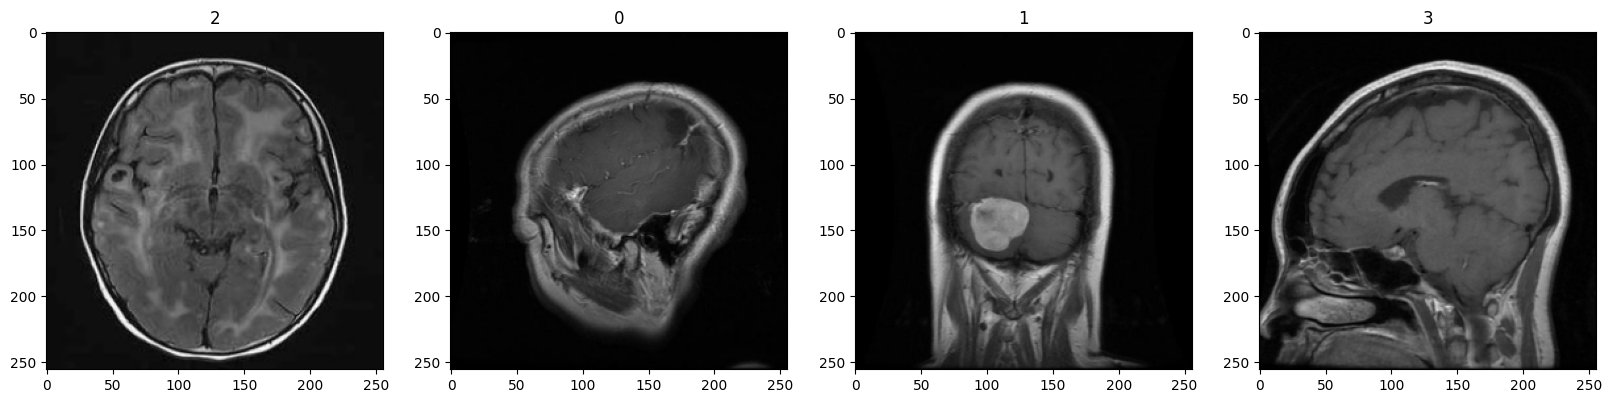

In [350]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img_index in enumerate([12,13,14,15]):
    ax[idx].imshow(batch_training[0][img_index].astype(int))
    ax[idx].title.set_text(batch_training[1][img_index])


In [351]:
# We are now dealing with just 2 lables, 0, 1, and 3 are tumor vs 2 which is non tumor

def map_labels(x,y):
    if y == 2:
        y = 0  # No tumor
    else:
        y = 1  # Tumor
    return x, y

def augment_image(x, y):

     # Random left-right flip
    x = tf.image.random_flip_left_right(x)
    # Random up-down flip
    x = tf.image.random_flip_up_down(x)

     # Random rotation (90-degree increments)
    num_rotations = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    x = tf.image.rot90(x, k=num_rotations)

    # # Random zoom (zooming in or out)
    # zoom_factor = tf.random.uniform(shape=[], minval=0.8, maxval=1.2)
    # crop_size = tf.cast(tf.cast(tf.shape(x)[0:2], dtype=tf.float32) * zoom_factor, dtype=tf.int32)
    # x = tf.image.central_crop(x, central_fraction=zoom_factor)
    # x = tf.image.resize(x, crop_size)
    # )
    # Add more augmentation functions as needed
    return x, y

In [352]:
tf.config.run_functions_eagerly(True)

num_classes = 4  # Adjust based on your number of classes

def get_positions(x, y):
    positions = tf.where(tf.equal(y, 1))
    positions = tf.gather(positions[:, 1], tf.where(y == 1)[:, 0])
    return x, positions


# Load the training dataset
Training_data = Training_data.map(augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))
Training_data = Training_data.map(get_positions)
Trainig_data = Training_data.map(map_labels)


# Load the validation dataset
Validation_data = Validation_data.map(augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Validation_data = Validation_data.map(augment_image)
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels

In [353]:
batch_training = Training_data.as_numpy_iterator().next()

In [354]:
xy=batch_training[1]
xy

array([0, 0, 0, 0, 1, 3, 3, 2, 3, 1, 1, 0, 3, 0, 0, 1, 3, 2, 3, 0, 1, 3,
       3, 2, 3, 3, 0, 1, 0, 1, 1, 1])